### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 7
### Due: Saturday, Mar 30th at 11.59pm CT
---

This is a regression problem. Many of the parts require minor variations of code to switch to new techniques, but otherwise using a similar workflow. 

Note of warning: the data I have provided have associated uncertainties, `yerr`. `sklearn` and `astroML` have different formats for using uncertainties; in `sklearn` fitting you can provide `sample_weight=1/yerr**2`, while in `astroML` fitting you can directly provide `y_error=yerr`.

1. Read in `hw7_data_1.npy`. The dataset should consist of $500$ samples. The first two columns are the two data features, `X`. The third column is the target labels, `y`, and the final column are the heteroscedastic uncertainties on the labels, `yerr`. Make a 2-panel scatter plot of the labels versus each feature.


2. Use multivariate linear regression on this data with its uncertainties (`astroML` rather than plain `sklearn` is the better option here). Print the best-fit intercept and slopes for the features. Make a prediction `Xgrid` over $50$ values from the min to the max value of each feature, and plot the best-fit model on a duplicate of the $2$-panel plot from (1); does this look like a good description of the data?


3. Make a new two-dimensional prediction meshgrid `Xgrid` over the $2$-D feature space, use your best-fit model to predict the labels, and make a $3$-D interactive plot showing the data and your best-fit over the entire space. You may find the following code useful.

In [60]:
import numpy as np 
import scipy
from scipy.stats import uniform, norm, rv_histogram
from scipy import stats
import matplotlib.pyplot as plt
from scipy import optimize
import chainconsumer
import corner
import dynesty
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from astroML.density_estimation import KNeighborsDensity
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn import preprocessing
from astroML.linear_model import (LinearRegression, PolynomialRegression,
                                  BasisFunctionRegression, NadarayaWatson)
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from astroML.linear_model import PolynomialRegression
from sklearn.model_selection import train_test_split



%matplotlib inline

In [4]:
# install the relevant interactive plot packages
# only do this once
!pip install ipywidgets ipympl

In [ ]:
# Makes the plot interactive. 
# You can pan the image.

### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(___, ___, y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(___.flatten(), ___.flatten(), ___, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

In [ ]:
### Always do this line at the start
### of a static plotting cell
%matplotlib inline

4. Sticking with a linear model, now attempt a `GridSearchCV` procedure on the data to find the best `Ridge` regression hyper-parameters. Use the following `param_grid`:
```
ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']}
```
What are the `best_params_` and the `best_score_` from this? Fit the data with the best options, and visualize interactively. Try `RidgeCV` also; what cross-validated `alpha_` does it return, and does this agree with `GridSeachCV`? *(Hint: remember to revert to inline matplotlib when you're done each time you make an interactive plot.)*


5. Now model the data using Gaussian process regression and the default kernel. Check what the fit looks like with and with and without uncertainties accounted for. *(Hint: GPR in `sklearn` takes an `alpha` parameter equal to `(yerr/y)**2`.)*


6. Let's look finally at polynomial fitting. Fit a $4$th degree polynomial to the data. Print the best-fit regression coefficients, predict on the 2D meshgrid, and visualize interactively as before. How does this look compared to the linear model and GPR models?


7. Sticking with polynomial fitting, let's find the optimal hyper-parameters through cross-validation. 
- Using `sklearn.model_selection.train_test_split`, first do a train-test split with a `test_size` of $20\%$. Then split out $20\%$ of the training set itself as a cross-validation set (leaving a somewhat smaller set to use for training). Note that you'll need to simultaneously split out `yerr` as well by just providing this as another array to `train_test_split`.
- Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from $1$ to $10$ inclusive. Plot the rms errors and BIC values as a function of the polynomial degree. 
- Choose the optimal polynomial degree, and train on all training data from the first `train_test_split` operation. Predict the labels of the held-out test set, and finally compute the testing rms error.

# 1

In [4]:
# LSS load data
loaddata = np.load('../../../homeworks/hw_data/hw7_data_1.npy')
X = loaddata[:, :2]
y = loaddata[:, 2]
yerr = loaddata[:, 3]

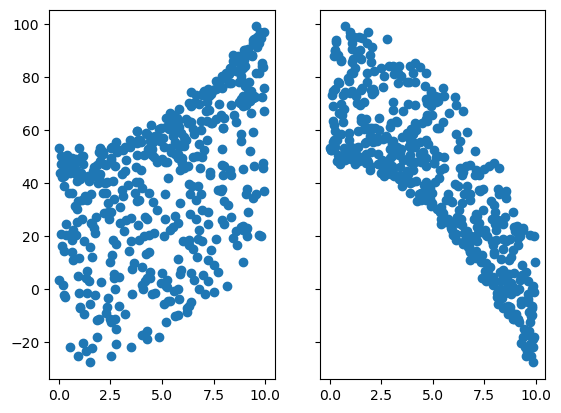

In [23]:
fig = plt.figure()
axes = fig.subplots(nrows=1, ncols=2, sharey=True)
axes[0].scatter(X[:, 0], y)
axes[1].scatter(X[:, 1], y)
plt.show()

# 2

In [31]:
linrgr = LinearRegression()
linrgr.fit(X, y, yerr)
print('incercept, feature1 coef, feature2 coef below')
print(linrgr.coef_)
linrgrint, mf1, mf2 = linrgr.coef_

incercept, feature1 coef, feature2 coef below
[57.10102323  4.94873016 -8.30023407]


In [24]:
# LSS finding feature min/max
print(np.min(X[:, 0]), np.max(X[:,0]))
print(np.min(X[:, 1]), np.max(X[:,1]))


0.029542954023376033 9.946084302327826
0.004170309106973358 9.950075144284998


In [28]:
f1range = np.linspace(0, 10, 50)
f2range = np.linspace(0, 10, 50)
Xgrid = np.vstack([f1range, f2range]).T
Xgrid.shape

(50, 2)

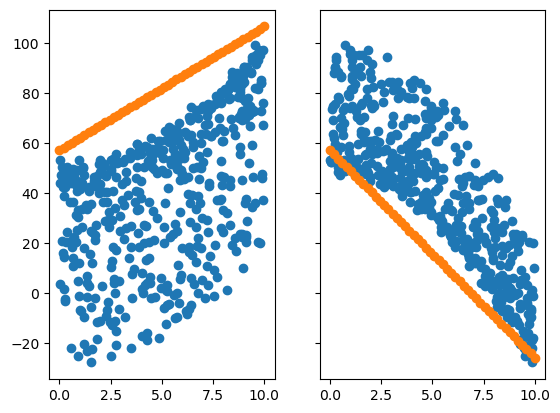

In [32]:
fig = plt.figure()
axes = fig.subplots(nrows=1, ncols=2, sharey=True)
# LSS plot original data
axes[0].scatter(X[:, 0], y)
axes[1].scatter(X[:, 1], y)

axes[0].scatter(Xgrid[:,0], mf1*Xgrid[:,0]+linrgrint)
axes[1].scatter(Xgrid[:,1], mf2*Xgrid[:,1]+linrgrint)
plt.show()

# 3

In [96]:
# LSS making a new grid
f1range = np.linspace(0, 10, 50)
f2range = np.linspace(0, 10, 50)
Xf1grid, Xf2grid = np.meshgrid(f1range, f2range)

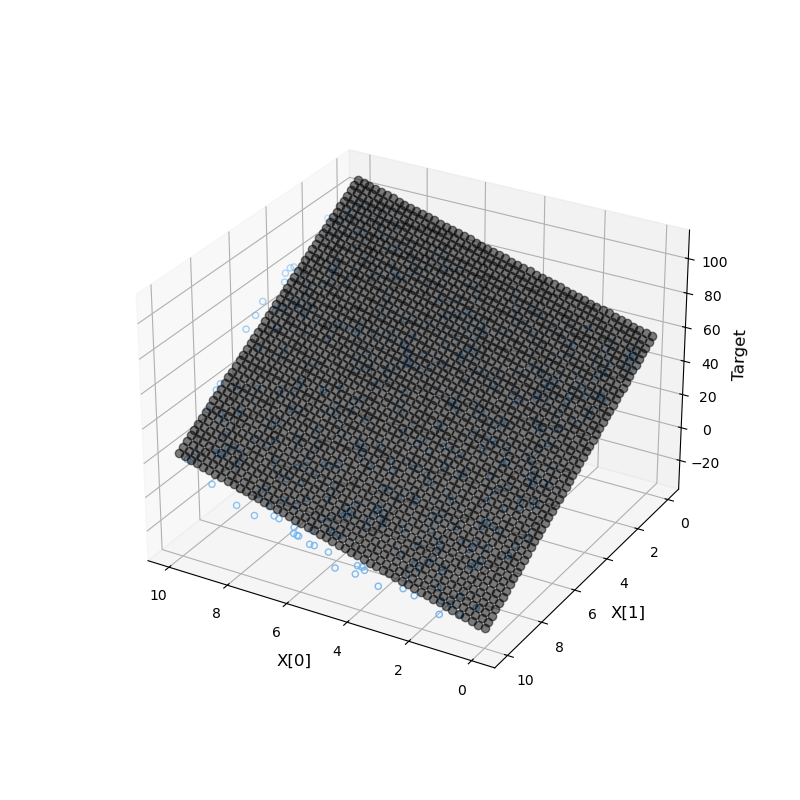

In [112]:
# Makes the plot interactive. 
# You can pan the image.

### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Xf1grid.flatten(), Xf2grid.flatten(), linrgr.predict(np.vstack([Xf1grid.flatten(), Xf2grid.flatten()]).T), color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), y, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

In [114]:
%matplotlib inline

# 4

In [41]:
# LSS from lecture 14
grid = GridSearchCV(Ridge(), {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']}, cv=5)
grid.fit(X, y)

bestal = grid.best_params_['alpha']
print("best alpha choice:", bestal)
bestso = grid.best_params_['solver']
print("best solver choice:", bestso)
bestscore = grid.best_score_
print("best score:", bestscore)


best alpha choice: 1.0
best solver choice: svd
best score: 0.9290800590702192


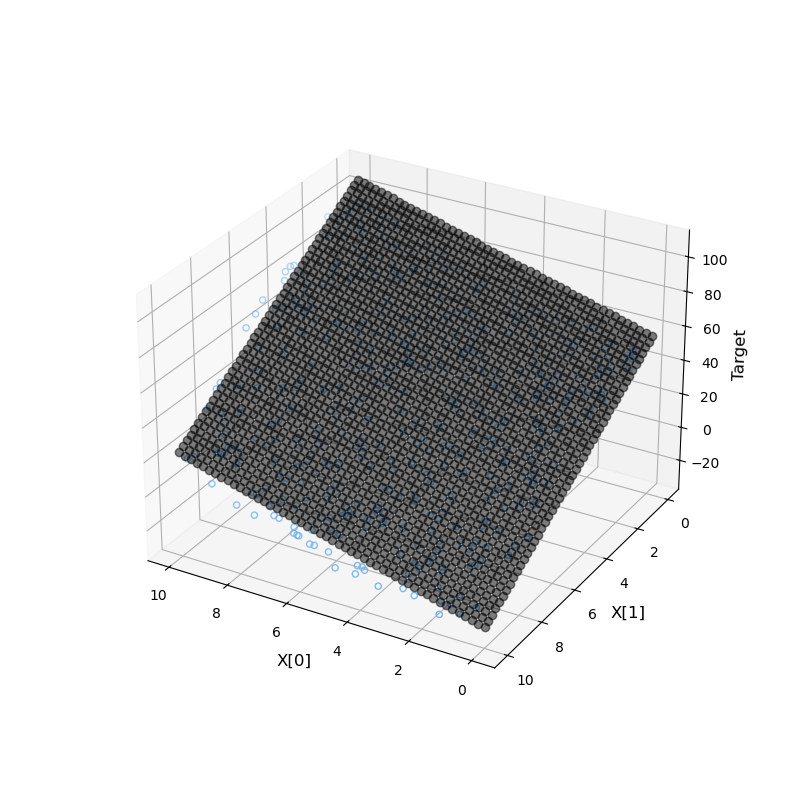

In [115]:
rdg = Ridge(alpha=bestal, solver=bestso)
rdg.fit(X, y)


# Makes the plot interactive. 
# You can pan the image.

### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Xf1grid.flatten(), Xf2grid.flatten(), rdg.predict(np.vstack([Xf1grid.flatten(), Xf2grid.flatten()]).T), color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), y, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

In [116]:
%matplotlib inline

In [117]:
ridgecv = RidgeCV(alphas=[0.05,0.1,0.2,0.5,1.0], cv=5) #Complete
ridgecv.fit(X, y)

print("best alpha choice (gridCV):", bestal)
bestalrcv = ridgecv.alpha_
print("best alpha choice (ridgeCV):", bestalrcv)



best alpha choice (gridCV): 1.0
best alpha choice (ridgeCV): 1.0


* hurrah! The CV methods give the same preferred alpha!

# 5

In [120]:
# LSS borrowing heavily from Lecture 18

#------------------------------------------------------------
# define a squared exponential covariance function
def squared_exponential(x1, x2, h):
    return np.exp(-0.5 * (x1 - x2) ** 2 / h ** 2)

# draw samples from the unconstrained covariance
x = np.linspace(0, 10, 25) #This sets the number of Gaussians
h = .5  #This is the Bandwidth

mu = np.zeros(len(x))
C = squared_exponential(x, x[:, None], h)
draws = np.random.multivariate_normal(mu, C, 3)

#------------------------------------------------------------
# Constrain the mean and covariance with two points

#kernel1 = kernels.RBF(0.5, (0.01, 10.0))
gp1 = GaussianProcessRegressor(normalize_y=True)
gp1.fit(X, y)
gppred, gppred_err = gp1.predict(np.vstack([Xf1grid.flatten(), Xf2grid.flatten()]).T, 
                         return_std=True)


## plotting GPR without errors accounted for

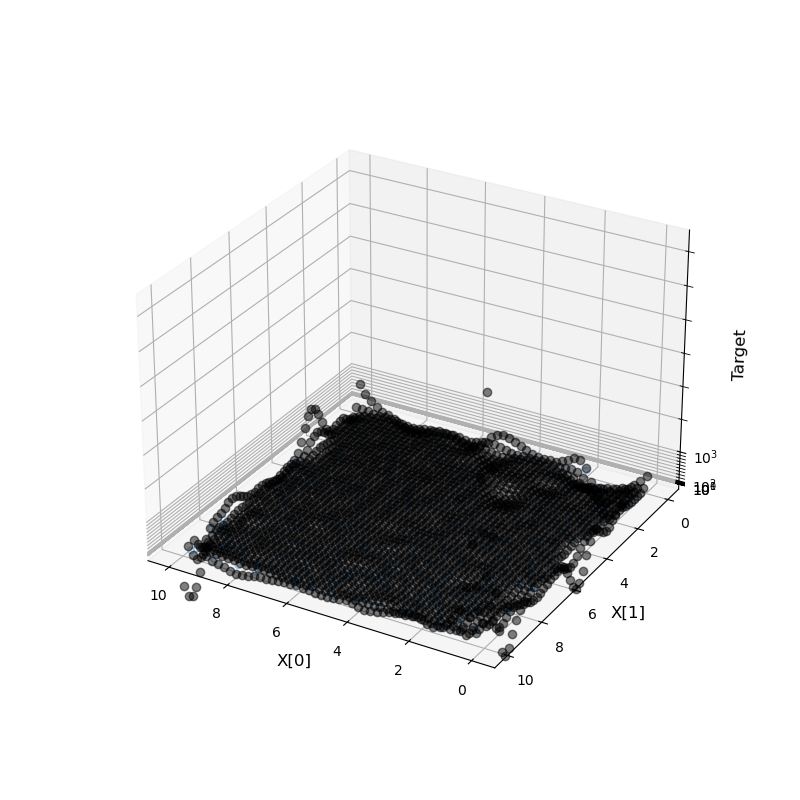

/Users/levischult/miniconda3/envs/astr8070/lib/python3.10/site-packages/ipympl/backend_nbagg.py:279: UserWarning: Attempt to set non-positive zlim on a log-scaled axis will be ignored.
  self.manager.handle_json(content)


In [122]:
# Makes the plot interactive. 
# You can pan the image.

### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Xf1grid.flatten(), Xf2grid.flatten(), gppred, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), y, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)
ax.set_zscale('log')

ax.view_init(elev=28, azim=120)

## Now GPR with errors accounted for

In [123]:
# LSS borrowing heavily from Lecture 18

#------------------------------------------------------------
# define a squared exponential covariance function
def squared_exponential(x1, x2, h):
    return np.exp(-0.5 * (x1 - x2) ** 2 / h ** 2)

# draw samples from the unconstrained covariance
x = np.linspace(0, 10, 25) #This sets the number of Gaussians
h = .5  #This is the Bandwidth

mu = np.zeros(len(x))
C = squared_exponential(x, x[:, None], h)
draws = np.random.multivariate_normal(mu, C, 3)

#------------------------------------------------------------
# Constrain the mean and covariance with two points

#kernel1 = kernels.RBF(0.5, (0.01, 10.0))
gp1 = GaussianProcessRegressor(normalize_y=True, alpha=(yerr / y) ** 2,)
gp1.fit(X, y)
gppred, gppred_err = gp1.predict(np.vstack([Xf1grid.flatten(), Xf2grid.flatten()]).T, 
                         return_std=True)


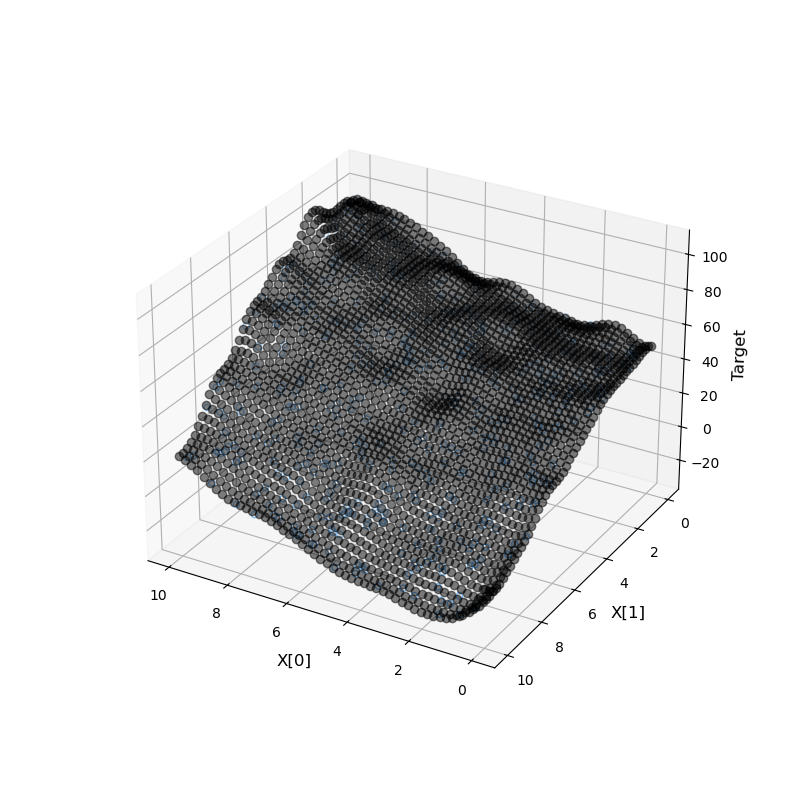

In [126]:
# Makes the plot interactive. 
# You can pan the image.

### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Xf1grid.flatten(), Xf2grid.flatten(), gppred, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), y, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

In [127]:
%matplotlib inline

# 6

In [128]:
# LSS more from Lecture 18
polymod = PolynomialRegression(degree=4)
polymod.fit(X,y)

print(polymod.coef_)

[ 5.00363666e+01  3.26437755e-01  7.04566290e-02  3.76478281e-01
 -2.37398556e-02 -8.70986046e-01  1.19122182e-02  2.54637597e-02
 -1.32002013e-02  2.02705370e-02 -4.53796076e-04 -5.21142180e-04
 -2.06194460e-03  1.68744189e-03 -1.52054198e-03]


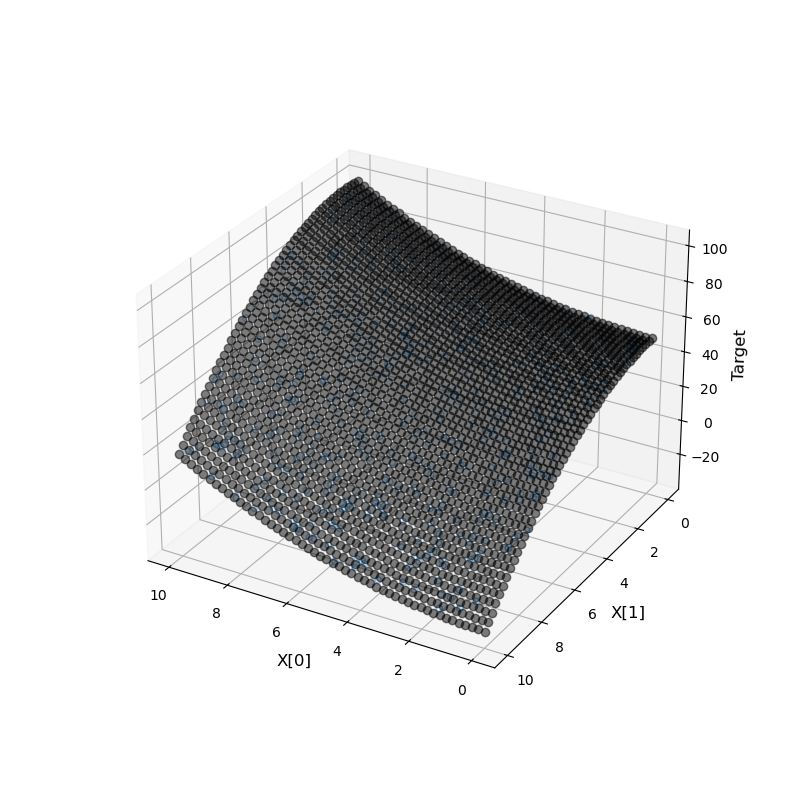

In [129]:
# Makes the plot interactive. 
# You can pan the image.

### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Xf1grid.flatten(), Xf2grid.flatten(), polymod.predict(np.vstack([Xf1grid.flatten(), Xf2grid.flatten()]).T), color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), y, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

In [130]:
%matplotlib inline

* this does better at following the surface of the data than linear regression
as the target surface is a bit twisted and distorted. I was expecting it to be 
overfitted, but with 500 degrees of freedom, 15 coefficients isn't a huge lift 
to fit
* GPR seemed to need a larger bandwidth to not be swayed by local dimples in the
target surface. GPR could also probably
have its model complexity reduced as it is currently using 25 gaussians to model
the dataset behavior.

# 7

In [64]:
X_train, X_test, y_train, y_test, yerr_train, yerr_test = train_test_split(X, y, yerr, train_size=0.8)

In [65]:
# LSS making training and validation datasets
X_Train, X_valid, y_Train, y_valid, yerr_Train, yerr_valid = train_test_split(X_train, y_train, yerr_train, train_size=0.8)

In [68]:
polydeg = np.arange(1, 11)


trainerr = []
cverr = []
nparam = [] # LSS save the number of parameters for each model (for BIC calc)
for degidx, deg in enumerate(polydeg):
    polymodel = PolynomialRegression(degree=deg)
    # LSS train model on training dataset
    polymodel.fit(X_Train, y_Train)
    nparam.append(polymodel.coef_.shape[0])
    ytrain_pred = polymodel.predict(X_Train) # LSS predicting from training set
    # LSS get rms error on training dataset
    ytrain_rms = np.sqrt(np.mean(np.square(y_Train-ytrain_pred)))
    # LSS predict using Cross validation dataset + eval rms error
    yvalid_pred = polymodel.predict(X_valid)
    yvalid_rms = np.sqrt(np.mean(np.square(y_valid-yvalid_pred)))

    # LSS save rms errors
    trainerr.append(ytrain_rms)
    cverr.append(yvalid_rms)

In [70]:
# LSS from hw4

def BIC_fromchi2(chi2, uncert, numparams, ndatapts):
    '''
    calculates the BIC for a model. note that max LOG likelihood is passed in
    '''
    np.sum(np.log(1/(uncert*np.sqrt(2*np.pi)))
    bic = numparams*np.log(ndatapts) - 2 * maxlnlik
    return bic

* now if minimizing the chi2 is the same as maximizing the likelihood, the question
is: how close is the rms error to the chi2? Are they one and the same? Me thinks
yes as the chi2 effectively measures how well the model fits the data, with smaller
chi2 being a better fit model

In [73]:
bic_train = [BIC(rms, npar, X_Train.shape[0]) for rms, npar in zip(trainerr, nparam)]
bic_valid = [BIC(rms, npar, X_valid.shape[0]) for rms, npar in zip(cverr, nparam)]

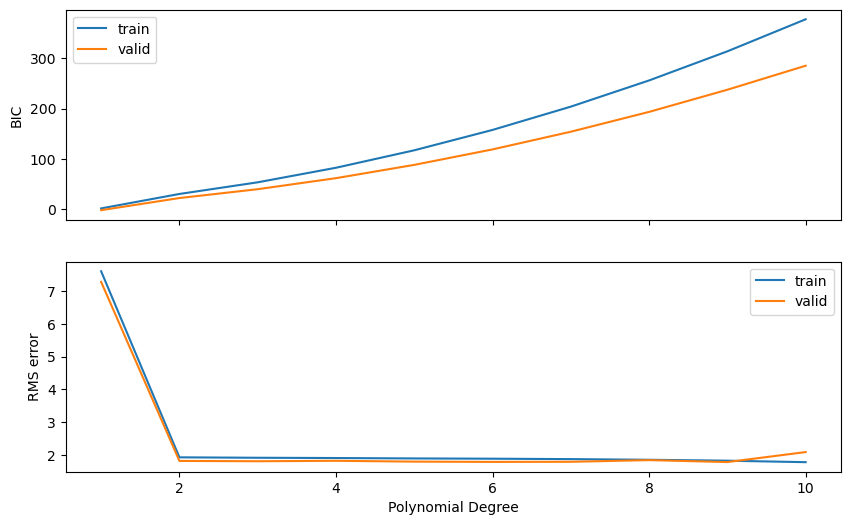

In [134]:
%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)
axes[0].plot(polydeg, bic_train, label='train')
axes[0].plot(polydeg, bic_valid, label='valid')
axes[0].legend()
axes[0].set_ylabel('BIC')
#axes[0].set_title('BIC')
axes[1].plot(polydeg, trainerr, label='train')
axes[1].plot(polydeg, cverr, label='valid')
axes[1].legend()
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('RMS error')
plt.show()



* I know the BIC isn't right - i just need to prioritize other things. 
Based on the rms improvement plateauing at a 2nd degree polynomial, I will use a
2nd degree polynomial for the final fit.

In [136]:
poly2deg = PolynomialRegression(degree=2)
poly2deg.fit(X_train, y_train, y_error=yerr_train)
ypred_2deg = poly2deg.predict(X_test)
poly2deg_testrms = np.sqrt(np.mean(np.square(y_test-ypred_2deg)))
print('2 degree polynomial regression rms error:', poly2deg_testrms)


2 degree polynomial regression rms error: 1.8657821072372318
